<h1 align="center">🎾 - Tennis Betting 👨‍💻🔬</h1>

<h2 align="center">EDA</h2>
<p style="text-align:center">
   Thomas Bury & Vilius Jaseliunas<br>
   Allianz<br>
</p>

# Database

In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from arfs.preprocessing import OrdinalEncoderPandas
from arfs.feature_selection import (
    Leshy,
    MissingValueThreshold,
    UniqueValuesThreshold,
    CollinearityThreshold,
    VariableImportance,
    make_fs_summary
)

data = pd.read_csv("../data/atp_data.csv", low_memory=False)
data['Date'] = pd.to_datetime(data['Date'])
data.head()


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


In [2]:
data.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'Wsets',
       'Lsets', 'Comment', 'PSW', 'PSL', 'B365W', 'B365L', 'elo_winner',
       'elo_loser', 'proba_elo'],
      dtype='object')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         44708 non-null  int64         
 1   Location    44708 non-null  object        
 2   Tournament  44708 non-null  object        
 3   Date        44708 non-null  datetime64[ns]
 4   Series      44708 non-null  object        
 5   Court       44708 non-null  object        
 6   Surface     44708 non-null  object        
 7   Round       44708 non-null  object        
 8   Best of     44708 non-null  int64         
 9   Winner      44708 non-null  object        
 10  Loser       44708 non-null  object        
 11  WRank       44708 non-null  int64         
 12  LRank       44708 non-null  int64         
 13  Wsets       44521 non-null  float64       
 14  Lsets       44521 non-null  float64       
 15  Comment     44708 non-null  object        
 16  PSW         32743 non-

Is the best ranked player the winner?

In [4]:
100 * (data["WRank"] < data["LRank"]).sum() / len(data)

65.60570815066654

we need to drop the number of sets won since it identifies almost 100% of the winner.

In [5]:
100 * (data["Wsets"] > data["Lsets"]).sum() / len(data)

98.21284781247203

# Renaming columns

To avoid obvious data leakage, rename the columns by replacing the W by P1 and L by P2. Then permute P1 and P2 1 every two rows (preventing the winner to be always P1).

**REM:** 

 - need to drop the number of sets won
 - need to compute the complementary elo probability since there is a single elo probability column, corresponding to the winning probability of the player who effectively won the game.

In [6]:
df = data.copy()
df = df.sort_values('Date')
df.columns = df.columns.str.lower()
df.rename(columns={'wrank': 'rank_p1', 
                   'lrank': 'rank_p2',
                   'wsets': 'sets_p1',
                   'lsets': 'sets_p2',
                   'psw': 'ps_p1',
                   'psl': 'ps_p2', 
                   'b365w': 'b365_p1',
                   'b365l': 'b365_p2'},
          inplace=True)
df.columns = df.columns.str.lower()
df.rename(columns=lambda x: x.replace('winner', 'p1').replace('loser', 'p2'), inplace=True)
# Print the modified column names
print(df.columns)


Index(['atp', 'location', 'tournament', 'date', 'series', 'court', 'surface',
       'round', 'best of', 'p1', 'p2', 'rank_p1', 'rank_p2', 'sets_p1',
       'sets_p2', 'comment', 'ps_p1', 'ps_p2', 'b365_p1', 'b365_p2', 'elo_p1',
       'elo_p2', 'proba_elo'],
      dtype='object')


In [7]:
p1_columns = df.filter(like='p1').columns
p2_columns = df.filter(like='p2').columns

print("Columns containing P1:")
print(p1_columns)

print("Columns containing P2:")
print(p2_columns)

Columns containing P1:
Index(['p1', 'rank_p1', 'sets_p1', 'ps_p1', 'b365_p1', 'elo_p1'], dtype='object')
Columns containing P2:
Index(['p2', 'rank_p2', 'sets_p2', 'ps_p2', 'b365_p2', 'elo_p2'], dtype='object')


# Shuffling players info

In [8]:
df_permuted = df.copy()
# swap the values P1 <-> P2 every two rows
mask = df.index % 2 == 1
df_permuted.loc[mask, p1_columns], df_permuted.loc[mask, p2_columns] = df.loc[mask, p2_columns].values, df.loc[mask, p1_columns].values

# # the complementary prob for the swapped rows
# # ELO proba (e.g. definition: https://ideas.repec.org/p/nbs/wpaper/2019-03.html#:~:text=The%20Elo%20rating%20system%20is,accuracy%2C%20calibration%20and%20model%20discrimination.)
df_permuted.loc[mask, "proba_elo"] = 1 - df_permuted.loc[mask, "proba_elo"].values

In [9]:
p2_columns

Index(['p2', 'rank_p2', 'sets_p2', 'ps_p2', 'b365_p2', 'elo_p2'], dtype='object')

In [10]:
player_columns = sorted(list(set(p1_columns).union(set(p2_columns))))
df[player_columns ].head()

,b365_p1,b365_p2,elo_p1,elo_p2,p1,p2,ps_p1,ps_p2,rank_p1,rank_p2,sets_p1,sets_p2
0,NaN,NaN,1500.000000,1500.0,Dosedel S.,Ljubicic I.,NaN,NaN,63,77,2.0,0.0
68,NaN,NaN,1516.736307,1500.0,Martin A.,Spadea V.,NaN,NaN,55,21,2.0,0.0
67,NaN,NaN,1516.000000,1500.0,Enqvist T.,Clement A.,NaN,NaN,5,56,2.0,0.0
66,NaN,NaN,1516.736307,1500.0,Escude N.,Baccanello P.,NaN,NaN,40,655,2.0,1.0
65,NaN,NaN,1484.000000,1500.0,Federer R.,Knippschild J.,NaN,NaN,65,87,2.0,0.0


In [11]:
df_permuted[player_columns ].head()

,b365_p1,b365_p2,elo_p1,elo_p2,p1,p2,ps_p1,ps_p2,rank_p1,rank_p2,sets_p1,sets_p2
0,NaN,NaN,1500.000000,1500.0,Dosedel S.,Ljubicic I.,NaN,NaN,63,77,2.0,0.0
68,NaN,NaN,1516.736307,1500.0,Martin A.,Spadea V.,NaN,NaN,55,21,2.0,0.0
67,NaN,NaN,1500.000000,1516.0,Clement A.,Enqvist T.,NaN,NaN,56,5,0.0,2.0
66,NaN,NaN,1516.736307,1500.0,Escude N.,Baccanello P.,NaN,NaN,40,655,2.0,1.0
65,NaN,NaN,1500.000000,1484.0,Knippschild J.,Federer R.,NaN,NaN,87,65,0.0,2.0


sanity check, is the permutation working as expected?

In [12]:
100 * (df_permuted["sets_p1"] > df_permuted["sets_p2"]).sum() / len(data)

49.257403596671736

In [13]:
100 * (df_permuted["rank_p1"] < df_permuted["rank_p2"]).sum() / len(data)

50.15209805851302

# Define the target
The target is the mask, whether or not the P1 and P2 have been swapped.

In [14]:
# does player 1 win?
df_permuted['target'] = ~mask
df_permuted.head()

,atp,location,tournament,date,series,court,surface,round,best of,p1,...,sets_p2,comment,ps_p1,ps_p2,b365_p1,b365_p2,elo_p1,elo_p2,proba_elo,target
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,0.0,Completed,NaN,NaN,NaN,NaN,1500.000000,1500.0,0.500000,True
68,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Martin A.,...,0.0,Completed,NaN,NaN,NaN,NaN,1516.736307,1500.0,0.524067,True
67,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Clement A.,...,2.0,Completed,NaN,NaN,NaN,NaN,1500.000000,1516.0,0.476990,False
66,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,...,1.0,Completed,NaN,NaN,NaN,NaN,1516.736307,1500.0,0.524067,True
65,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Knippschild J.,...,2.0,Completed,NaN,NaN,NaN,NaN,1500.000000,1484.0,0.523010,False


drop the number of sets won by each player because it would identify 1-1 (almost) the winner.

# Feature engineering
To be improved

In [15]:

# Extract year, month, and day into separate columns
df_permuted['year'] = df_permuted['date'].dt.year
df_permuted['month'] = df_permuted['date'].dt.month
df_permuted['day'] = df_permuted['date'].dt.day
df_permuted['rank_diff'] = df_permuted['rank_p1'] - df_permuted['rank_p2']

# find the player with the best (lowest) ATP rank
df_permuted['best_ranked'] = 'p1'
df_permuted.loc[df_permuted['rank_diff'] > 0, 'best_ranked'] = 'p2'

## Split the data

As the time goes by, players improve or age. It's important to keep the time ordering to avoid leakage of information

In [16]:
df_permuted['date'].head()

0    2000-01-03
68   2000-01-03
67   2000-01-03
66   2000-01-03
65   2000-01-03
Name: date, dtype: datetime64[ns]

In [17]:
df_permuted['date'].tail()

44703   2018-03-03
44704   2018-03-03
44705   2018-03-03
44706   2018-03-04
44707   2018-03-04
Name: date, dtype: datetime64[ns]

In [18]:
# they are only NaN
predictors = df_permuted.columns.drop(['target', 'date', 'sets_p1', 'sets_p2', 'b365_p1', 'b365_p2', 'ps_p1', 'ps_p2'])
# predictors = ['rank_p1', 'rank_p2']
X = df_permuted[predictors].copy()
y = df_permuted['target'].copy() * 1

In [19]:
predictors

Index(['atp', 'location', 'tournament', 'series', 'court', 'surface', 'round',
       'best of', 'p1', 'p2', 'rank_p1', 'rank_p2', 'comment', 'elo_p1',
       'elo_p2', 'proba_elo', 'year', 'month', 'day', 'rank_diff',
       'best_ranked'],
      dtype='object')

In [20]:
ts_split = TimeSeriesSplit(n_splits=2)
all_splits = list(ts_split.split(X, y))
train_idx, test_idx = all_splits[0]

In [21]:
train_idx

array([    0,     1,     2, ..., 14901, 14902, 14903])

sanity check: are the matches chronologically ordered?

In [22]:
df_permuted['date'].iloc[train_idx].tail()

14895   2006-02-16
14894   2006-02-16
14893   2006-02-16
14892   2006-02-16
14891   2006-02-16
Name: date, dtype: datetime64[ns]

In [23]:
df_permuted['date'].iloc[test_idx].head()

14890   2006-02-16
14889   2006-02-16
14897   2006-02-16
14921   2006-02-17
14920   2006-02-17
Name: date, dtype: datetime64[ns]

## Train the model

### Business rule

The lowest rank wins

In [24]:
X_train = X.iloc[train_idx, :].copy()
y_train = y[train_idx].copy()
X_test= X.iloc[test_idx, :].copy()
y_test = y[test_idx].copy()

In [25]:
X_test['best_ranked'].value_counts()

p1    7481
p2    7421
Name: best_ranked, dtype: int64

In [26]:
y_pred_br = X_test["rank_diff"]<0

target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred_br, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.51      0.51      0.51      7451
       loser       0.51      0.51      0.51      7451

    accuracy                           0.51     14902
   macro avg       0.51      0.51      0.51     14902
weighted avg       0.51      0.51      0.51     14902



In [27]:
confusion_matrix = pd.crosstab(y_test, X_test["rank_diff"]<0, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,False,True
Actual,,
0,4907,2540
1,2512,4934


### Vanilla RF

RF is basically only overfitting, not extracting info

In [28]:
model= Pipeline([ ("encoder", OrdinalEncoderPandas()), ('imputer', SimpleImputer(strategy='most_frequent')), ("gbm", RandomForestClassifier())])
model.fit(X_train, y_train)

Pipeline(steps=[('encoder', OrdinalEncoderPandas()),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('gbm', RandomForestClassifier())])

In [29]:
y_pred_insample = model.predict(X_train)
target_names = ["winner", "loser"]
print(classification_report(y_train, y_pred_insample, target_names=target_names))

              precision    recall  f1-score   support

      winner       1.00      1.00      1.00      7452
       loser       1.00      1.00      1.00      7452

    accuracy                           1.00     14904
   macro avg       1.00      1.00      1.00     14904
weighted avg       1.00      1.00      1.00     14904



In [30]:
y_pred = model.predict(X_test.fillna(0))
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.51      0.54      0.53      7451
       loser       0.52      0.49      0.50      7451

    accuracy                           0.51     14902
   macro avg       0.51      0.51      0.51     14902
weighted avg       0.51      0.51      0.51     14902



In [31]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,4042,3409
1,3821,3630


### Vanilla GBM
vanilla ligthGBM for now, not even early stopping. 

In [32]:
model= Pipeline([ ("encoder", OrdinalEncoderPandas()), ("gbm", LGBMClassifier(n_estimators=20))])
model.fit(X_train, y_train)

y_pred_insample = model.predict(X_train)
target_names = ["winner", "loser"]
print(classification_report(y_train, y_pred_insample, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.66      0.62      0.64      7452
       loser       0.64      0.68      0.66      7452

    accuracy                           0.65     14904
   macro avg       0.65      0.65      0.65     14904
weighted avg       0.65      0.65      0.65     14904



In [33]:
y_pred = model.predict(X_test)
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.51      0.57      0.54      7451
       loser       0.51      0.45      0.48      7451

    accuracy                           0.51     14902
   macro avg       0.51      0.51      0.51     14902
weighted avg       0.51      0.51      0.51     14902



In [34]:
print(accuracy_score(y_test, y_pred))

0.507649979868474


In [35]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,4232,3219
1,4118,3333


### Vanilla XGBoost

In [36]:
model= Pipeline([ ("encoder", OrdinalEncoderPandas()), ("gbm", XGBClassifier(n_estimators=20))])
model.fit(X_train, y_train)

y_pred_insample = model.predict(X_train)
target_names = ["winner", "loser"]
print(classification_report(y_train, y_pred_insample, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.69      0.66      0.67      7452
       loser       0.67      0.70      0.69      7452

    accuracy                           0.68     14904
   macro avg       0.68      0.68      0.68     14904
weighted avg       0.68      0.68      0.68     14904



In [37]:
y_pred = model.predict(X_test)
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.51      0.56      0.53      7451
       loser       0.51      0.46      0.48      7451

    accuracy                           0.51     14902
   macro avg       0.51      0.51      0.51     14902
weighted avg       0.51      0.51      0.51     14902



In [38]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,4171,3280
1,4029,3422


### Vanilla CatBoost

In [39]:
model= Pipeline([ ("encoder", OrdinalEncoderPandas()), ("gbm", CatBoostClassifier(n_estimators=50))])
model.fit(X_train, y_train)

y_pred_insample = model.predict(X_train)
target_names = ["winner", "loser"]
print(classification_report(y_train, y_pred_insample, target_names=target_names))

Learning rate set to 0.5
0:	learn: 0.6904354	total: 148ms	remaining: 7.27s
1:	learn: 0.6883207	total: 159ms	remaining: 3.81s
2:	learn: 0.6866370	total: 168ms	remaining: 2.63s
3:	learn: 0.6851492	total: 175ms	remaining: 2.02s
4:	learn: 0.6838091	total: 184ms	remaining: 1.66s
5:	learn: 0.6817825	total: 193ms	remaining: 1.42s
6:	learn: 0.6806844	total: 201ms	remaining: 1.24s
7:	learn: 0.6797442	total: 209ms	remaining: 1.1s
8:	learn: 0.6787334	total: 218ms	remaining: 992ms
9:	learn: 0.6778913	total: 228ms	remaining: 911ms
10:	learn: 0.6762401	total: 235ms	remaining: 833ms
11:	learn: 0.6749512	total: 244ms	remaining: 772ms
12:	learn: 0.6737839	total: 253ms	remaining: 721ms
13:	learn: 0.6721775	total: 263ms	remaining: 675ms
14:	learn: 0.6699724	total: 272ms	remaining: 636ms
15:	learn: 0.6683424	total: 281ms	remaining: 597ms
16:	learn: 0.6666039	total: 289ms	remaining: 561ms
17:	learn: 0.6655585	total: 297ms	remaining: 527ms
18:	learn: 0.6638545	total: 304ms	remaining: 496ms
19:	learn: 0.6618

In [40]:
y_pred = model.predict(X_test)
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.51      0.51      0.51      7451
       loser       0.51      0.50      0.50      7451

    accuracy                           0.51     14902
   macro avg       0.51      0.51      0.51     14902
weighted avg       0.51      0.51      0.51     14902



In [41]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,3797,3654
1,3709,3742


### Vanilla + FS

In [42]:
arfs_model = LGBMClassifier(random_state=42, verbose=-1, objective="binary", zero_as_missing=False, n_estimators=10)
lgb_kwargs = {"objective": "binary", "zero_as_missing": False, "num_iterations": 10}

fs = Pipeline([
        ("missing", MissingValueThreshold(threshold=0.05)),
        ("unique", UniqueValuesThreshold(threshold=1)),
        # ("collinearity", CollinearityThreshold(threshold=0.95)),
        ("lowimp", VariableImportance(verbose=2, threshold=0.99, lgb_kwargs=lgb_kwargs, encode=True)),
        # ("arfs", Leshy(arfs_model, n_estimators=100, verbose=0, max_iter=10, random_state=42, importance="shap"))
    ])

fs_model= Pipeline([ ("encoder", OrdinalEncoderPandas()), ("fs", fs), ("gbm", LGBMClassifier(n_estimators=20))])

fs_model.fit(X_train, y_train)

y_pred = fs_model.predict(X_test)
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

Iteration nb: 9  : 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


              precision    recall  f1-score   support

      winner       0.51      0.57      0.54      7451
       loser       0.51      0.45      0.48      7451

    accuracy                           0.51     14902
   macro avg       0.51      0.51      0.51     14902
weighted avg       0.51      0.51      0.51     14902



In [43]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,4231,3220
1,4108,3343


In [44]:
make_fs_summary(fs_model.named_steps["fs"])

,predictor,missing,unique,lowimp
0,atp,1,1,1
1,location,1,1,1
2,tournament,1,1,1
3,series,1,1,0
4,court,1,1,0
5,surface,1,1,1
6,round,1,1,1
7,best of,1,1,0
8,p1,1,1,1
9,p2,1,1,1


In [45]:
fs_model.named_steps["fs"]["lowimp"]

VariableImportance(lgb_kwargs={'metric': 'binary', 'num_iterations': 10,
                               'objective': 'binary', 'verbosity': -1,
                               'zero_as_missing': False},
                   verbose=2)

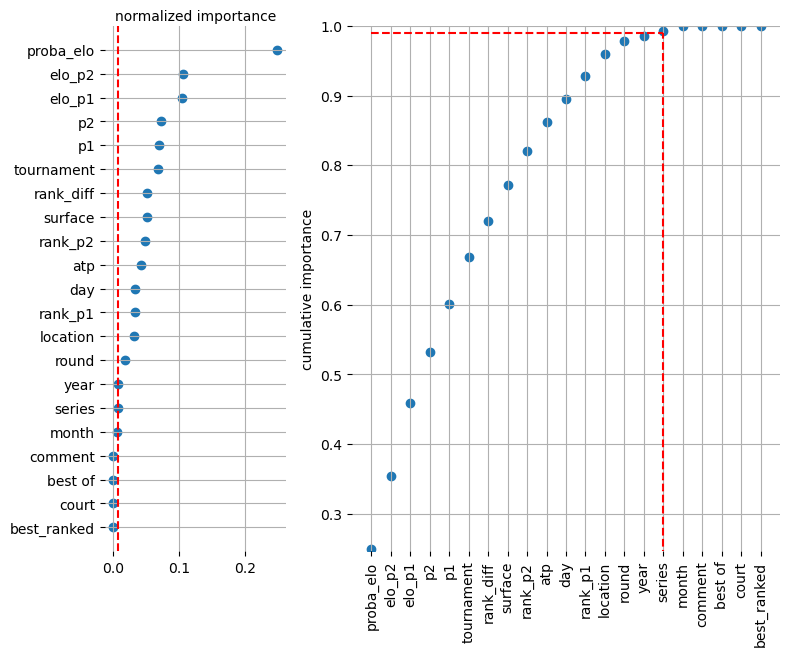

In [46]:
fs_model.named_steps["fs"]["lowimp"].plot_importance(log=False, style=None)

### HPO

``multivariate`` option is an experimental feature. The interface can change in the future.


Optimizing hyper-parameter for max 3600 s
Study not found or not provided, creating:
C:/Users/xtbury/Documents/Projects/mlops_ds/hpo/hpo_steptuner_binary_study.joblib


min_data_in_leaf, val_score: 0.692695: 100%|##########| 5/5 [00:00<00:00,  7.65it/s]


Saving study to:     C:/Users/xtbury/Documents/Projects/mlops_ds/hpo/hpo_steptuner_binary_study.joblib
Saving best params to:     C:/Users/xtbury/Documents/Projects/mlops_ds/hpo/hpo_steptuner_binary_best_params.json
Fitting the model with params: 
    objective: binary
    metric: binary_logloss
    verbose: -1
    feature_pre_filter: False
    lambda_l1: 2.6975172405518486e-06
    lambda_l2: 0.2748958623607287
    num_leaves: 4
    feature_fraction: 1.0
    bagging_fraction: 0.9988934219153236
    bagging_freq: 7
    min_child_samples: 5
Saving model as: C:/Users/xtbury/Documents/Projects/mlops_ds/hpo/hpo_steptuner_binary.joblib


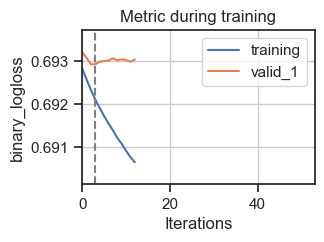

In [58]:
from taco.automation.premium import (fit_modelling_pipeline,
                                     get_columns_to_keep,
                                     filter_negative_claim_amount,
                                     create_pricing_targets,
                                     random_split_train_test,
                                     extract_variables)

path_dic = {"input": "C:/Users/xtbury/Documents/Projects/mlops_ds/hpo/", "output": "C:/Users/xtbury/Documents/Projects/mlops_ds/hpo/", "study": "C:/Users/xtbury/Documents/Projects/mlops_ds/hpo/"}

fitted_pipe = fit_modelling_pipeline(
    X=X_train,
    y=y_train,
    sample_weight=None,
    groups=None,
    hpo=True,
    model_type="gbm",
    objective="binary",
    task="binary",
    tweedie_power=1.5,
    glm_ridge_param=2, # to be optmized
    feature_selection=False,
    save_path_dic=path_dic)

# fitted_pipe.set_params(model=fitted_pipe.named_steps["model"].model)

In [60]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0
Actual,
0,7451
1,7451


In [61]:
y_pred = fitted_pipe.predict(X_test)
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.51      0.38      0.44      7451
       loser       0.51      0.64      0.57      7451

    accuracy                           0.51     14902
   macro avg       0.51      0.51      0.50     14902
weighted avg       0.51      0.51      0.50     14902

